In [41]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using SparseArrays
using ForwardDiff
using OSQP
using RobotDynamics
using RobotZoo: PlanarRocket
using RobotZoo
using StaticArrays
using Plots
include("rocket.jl")

 Activating environment at `~/Classes/OptimalControl/hw2/Project.toml`


comparison_plot (generic function with 1 method)

# Question 3: Writing an MPC Controller
In this problem we'll compare the performance of LQR with a QP-based MPC controller for landing a rocket booster. 

## The Dynamics
We'll be solving a simplified version of the rocket soft landing problem. We'll only be considering a planar version where we control the lateral and vertical movement of the rocket by rotating the thrust vector. The dynamics are as follows:

$$ 
x = \begin{bmatrix} p_x \\ p_z \\ \theta \\ v_x \\ v_z \\ \omega \\ T \\ \phi \end{bmatrix}, \quad
u = \begin{bmatrix} \dot{T} \\ \dot{\phi} \end{bmatrix}, \quad
\dot{x} = \begin{bmatrix}
v_z \\ v_z \\ \omega \\
\frac{T}{m} \cos{(\theta + \phi)} \\ 
\frac{T}{m} \sin{(\theta + \phi)} \\
\frac{T}{2J} L \sin(\phi) \\
\dot{T} \\ \dot{\phi}
\end{bmatrix}
$$
where $p_x$ is the lateral displacement, $p_z$ is the altitude, $\theta$ is the roll angle, $v_x$ and $v_z$ are the linear velocities, $\omega$ is the roll rate, $T$ is the total thrust, $\phi$ is the thrust angle, $\dot{T}$ and $\dot{\phi}$ are the thrust and thrust angle rates, $m$ is the mass, $J$ is the moment of inertia, $L$ is the distance from the thruster to the center of mass, and $g$ is gravity.

To keep our solution stable and safe, we'll saturate our thrust to be between 75%-150% of the nominal gravity-compensating thrust, our thrust angle with $\pm$10 degrees, and our roll angle between $\pm$5 degrees.

Again, we've already defined a `RobotDynamics` model that implements these dynamics for you, but it's helpful to understand the dynamics model you're working with.

In [2]:
# Planar Rocket model
model = PlanarRocket(max_roll=5.0)
n,m = state_dim(model), control_dim(model)
xeq = [zeros(6); model.m*model.g; 0]
ueq = zeros(2) 
norm(dynamics(model, xeq, ueq)) ≈ 0 # make sure it's an equilibrium point
dt = 0.1  # time step (s)
tf = 25   # time horizon (s)
N = Int(tf / dt) + 1

# Evaluate the continuous and discrete Jacobians
zeq = KnotPoint(xeq,ueq,dt)   # create a `KnotPoint` type that stores everything together
∇f = RobotDynamics.DynamicsJacobian(model)
jacobian!(∇f, model, zeq)
discrete_jacobian!(RK4, ∇f, model, zeq)

# Extract pieces of the Jacobian
A = ∇f.A
B = ∇f.B;

# Cost matrices (using Bryson's Rule)
Q = Diagonal([
    1.0/5^2; 
    1.0/5^2; 
    1.0/(10*pi/180)^2; 
    10.0/5^2; 
    10.0/5^2; 
    10.0/(10*pi/180)^2;
    1/(.1*model.m*model.g)^2; 
    1/(10*pi/180)^2
])
R = Diagonal([
    1/(20*model.m*model.g)^2,
    1/(deg2rad(10))^2
])

2×2 Diagonal{Float64,Array{Float64,1}}:
 2.59778e-9    ⋅ 
  ⋅          32.8281

## Part (a): Design a reference trajectory
As we saw in previous problem, we'll need a reference trajectory for our controller. However, in this case our reference trajectory is a very simple trajectory that provides a reasonable guess but we expect the actual solution to be different. We'll later see how this reference trajectory affects the performance of our controller.

For the rocket problem, we'll be starting at an altitude of 500m and 200m to the West of our landing location. We'll use a simple linear interpolation from our expected initial state and our goal location. 

In [4]:
# TASK: implement this method
"""
    nominal_trajectory(x0, N, dt)

Generate the nominal trajectory for the rocket problem, given the initial state `x0`,
horizon length `N`, and time step `dt`. 

The guess should be a linear interpolation of the positions.
The velocities should should be consistent with the positions (i.e. constant).
The last state should be have position and velocity of 0, but the same nominal
actuator commands as initial state (i.e. T and ϕ should be constant)

**TIP**: Use a simple finite difference to calculate the velocities.
"""
function nominal_trajectory(x0,N,dt)
    Xref = [zero(x0) for k = 1:N]
    
    # TODO: Design a trajectory that linearly interpolates from x0 to the origin
    # SOLUTION: 
    # linear interpolate the positions
    for k = 1:N
        Xref[k][1:2] .= ((N-k)/(N-1))*x0[1:2]
        Xref[k][7:8] .= x0[7:8] # keep T, ϕ constant
    end
    # calculate the velocities
    for k = 1:N-1
        Xref[k][4:5] .= (Xref[2][1:2]-Xref[1][1:2])/dt
    end
    
    return SVector{8}.(Xref)
end

nominal_trajectory

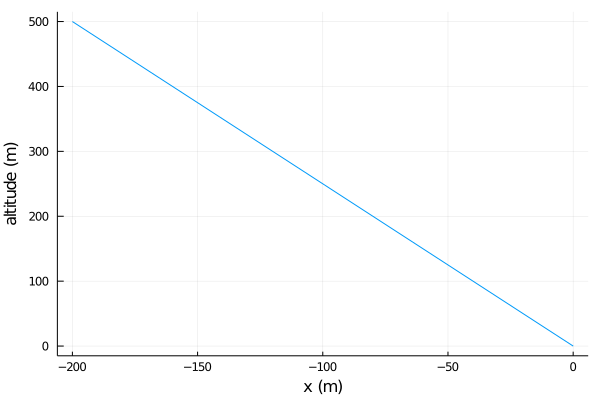

In [16]:
# Start 500m off the ground and 200m West
x0_ref = [-200, 500, 0, 0, 0, 0, 0, 0.] + xeq

# Generate reference trajectory
Xref = nominal_trajectory(x0_ref,N,dt)
Uref = [copy(ueq) for k = 1:N]
tref = range(0,tf, length=N)

# Plot the trajectory
traj2(Xref, xlabel="x (m)", ylabel="altitude (m)", label="")

## Part (b): Design an LQR Controller
As we saw in Q1, a simple infinite-gain LQR controller can work extremely effectively. Write a method to calculate the infinite-horizon gain `K` and cost-to-go `P`. We'll use `K` to control our system and `P` as the $Q_f$ weight matrix for our MPC controller later.

**EXTRA CREDIT**:
The simplest method to calculate the infinite-horizon LQR solution is to just the finite-horizon recursion until it converges to a steady-state value. However, there are other methods. We'll offer extra to anyone who implements an alternative method to running the Riccati recursion until convergence. Simply calling `dlqr` in ControlSystems.jl will not count. You're welcome to use it to check your solution, however.

In [11]:
# TASK: Implement the following methods:
#       get_control
#       lqr

"""
    LQRController

Type for evaluting an infinite-horizon time-invariant LQR control policy. 
"""
struct LQRController
    K::Matrix{Float64}
    Xref::Vector{Vector{Float64}}
    Uref::Vector{Vector{Float64}}
    times::Vector{Float64}
end

"""
    get_k(ctrl, t)

Get the time index corresponding to time `t`. 
Useful for implementing zero-order hold control.
Uses binary search to find the time index.
"""
get_k(controller, t) = searchsortedlast(controller.times, t)

"""
    get_control(ctrl, x, t)

Evaluate the LQR feedback policy at state `x` and time `t`, returning the control 
to be executed by the system.
"""
function get_control(ctrl::LQRController, x, t)
    k = get_k(ctrl, t)
    # TODO: Implement the control policy
    # SOLUTION
    u = ctrl.Uref[k] - ctrl.K*(x - ctrl.Xref[k])
    return u
end

"""
    lqr(A,B,Q,R; kwargs...)

Calculate the infinite-horizon LQR gain from dynamics Jacobians `A` and `B` and
cost matrices `Q` and `R`. Returns the infinite-horizon gain `K` and cost-to-go `P`.

# Keyword Arguments
* `P`: Provide an initial guess for the infinite-horizon gain
* `max_iters`: maximum number of iterations
* `tol`: tolerance for solve
` `verbose`: print the number of iterations
"""
function lqr(A,B,Q,R; P=Matrix(Q), tol=1e-8, max_iters=400, verbose=false)
    # initialize the output
    n,m = size(B)
    K = zeros(m,n)
    
    # TODO: calculate the infinite-horizon LQR solution

    # SOLUTION
    Kprev = zero(K)
    for k = 1:max_iters
        K .= (R + B'P*B)\(B'P*A)
        P .= Symmetric(Q + A'P*A - A'P*B*K)
        if norm(K-Kprev) < tol
            verbose && println("Converged in $k iters")
            break
        end
        Kprev .= K
        if k == max_iters
            @warn "Max iterations"
        end
    end
    
    # return the feedback gains and ctg matrices
    return K,P
end

lqr

In [17]:
# Create LQR controller
K,Qf = lqr(A,B,Q,R)
ctrl = LQRController(K,Xref,Uref,tref);

In [18]:
# Simulate and visualize the result
vis = initialize_visualizer(model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8703
└ @ MeshCat /home/brian/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("gimbal" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("cone" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6d, 0x62, 0x61, 0x6c, 0x2f, 0x63, 0x6f, 0x6e, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6d, 0x62, 0x61, 0x6c, 0x2f, 0x63, 0x6f, 0x6e, 0x65], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"tip" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x74, 0x69, 0x70], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"fins" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x69, 0x6e, 0x73], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8703))

In [21]:
Xlqr,Ulqr,tlqr = simulate(model, Xref[1], ctrl, tf=50)
visualize!(vis, model, tlqr[end] / 10, Xlqr)  # divide the time to speed it up

Controller ran at 1.107111302873641e6 Hz


## Part (c): Design an MPC Controller
We'll now design QP-based MPC controller for our rocket. We've set up the basic structure below, which is already setup to work with OSQP. Your job is to generate the QP OSQP will need to solve at each iteration.

Your QP should look something like this:
$$ \begin{align}
    &\text{minimize}_{z} && \frac{1}{2} z^T P z + q^T z \\
    &\text{subject to} && D z = d \\
    &&& C z \leq d \\
\end{align} $$

where $z$ is the concatenated vector of states and controls at each time step. The equality constraints are just the linearized dynamics constraints:

$$ 
\begin{bmatrix} 
    B & -I \\ 
      & A & B & -I \\
      &   &   &   & \ddots \\
      &   &   &   & & A & B -I \\
\end{bmatrix}
\begin{bmatrix} u_0 \\ x_1 \\ u_1 \\ \vdots \\ x_{N-1} \\ u_{N-1} \\ x_N \end{bmatrix} = 
\begin{bmatrix} -A (x_1 - x_{eq}) \\ 0 \\ \vdots \\ 0 \end{bmatrix}
$$

and the cost matrices $P$ and $q$ look are defined as:
$$
P = \begin{bmatrix}
R \\
& Q \\
&& \ddots \\
&&& R \\
&&&& Q_f
\end{bmatrix}, \quad
q = \begin{bmatrix}
    -R(\bar{u}_1 - u_{eq}) \\
    -Q(\bar{x}_2 - x_{eq}) \\
    \vdots \\
    -R(\bar{u}_{N-1} - u_{eq}) \\
    -Q_f(\bar{x}_N - x_{eq}) \\
\end{bmatrix}
$$

Note that the states and controls in our QP are defined relative to our linearization point at the origin $(x_{eq}, u_{eq})$. As the MPC progresses along the horizon, the reference states and controls $(\bar{x},\bar{u})$ will change.

We won't have inequality constraints in this part, but we'll add them in the next section!

In [26]:
# TASK: Implement the following methods:
#       build_QP!
#       update_QP!
"""
    MPCController

An MPC controller that uses a solver of type `S` to solve a QP at every iteration.

It will track the reference trajectory specified by `Xref`, `Uref` and `times` 
with an MPC horizon of `Nmpc`. It will track the terminal reference state if 
the horizon extends beyond the reference horizon.
"""
struct MPCController{S}
    P::SparseMatrixCSC{Float64,Int}
    q::Vector{Float64}
    A::SparseMatrixCSC{Float64,Int}
    lb::Vector{Float64}
    ub::Vector{Float64}
    Nmpc::Int
    solver::S
    Xref::Vector{Vector{Float64}}
    Uref::Vector{Vector{Float64}}
    times::Vector{Float64}
end

"""
    OSQPController(n,m,N,Nref,Nd)

Generate an `MPCController` that uses OSQP to solve the QP.
Initializes the controller with matrices consistent with `n` states,
`m` controls, and an MPC horizon of `N`, and `Nref` constraints. 

Use `Nref` to initialize a reference trajectory whose length may differ from the 
horizon length.
"""
function OSQPController(n::Integer, m::Integer, N::Integer, Nref::Integer=N, Nd::Integer=(N-1)*n)
    Np = (N-1)*(n+m)   # number of primals
    P = spzeros(Np,Np)
    q = zeros(Np)
    A = spzeros(Nd,Np)
    lb = zeros(Nd)
    ub = zeros(Nd)
    Xref = [zeros(n) for k = 1:Nref]
    Uref = [zeros(m) for k = 1:Nref]
    tref = zeros(Nref)
    solver = OSQP.Model()
    MPCController{OSQP.Model}(P,q, A,lb,ub, N, solver, Xref, Uref, tref)
end

"""
    buildQP!(ctrl, A,B,Q,R,Qf; kwargs...)

Build the QP matrices `P` and `A` for the MPC problem. Note that these matrices
should be constant between MPC iterations.

Any keyword arguments will be passed to `initialize_solver!`.
"""
function buildQP!(ctrl::MPCController, A,B,Q,R,Qf; kwargs...)
    # TODO: Implement this method to build the QP matrices
    
    # SOLUTION:
    Nt = ctrl.Nmpc-1
    Nx = length(ctrl.Xref[1])    # number of states
    Nu = length(ctrl.Uref[1])    # number of controls

    max_roll = deg2rad(model.max_roll)
    xeq = Xref[end]
    aeq = xeq[7:8]  # actuators
    
    H = sparse([kron(Diagonal(I,Nt-1),[R zeros(Nu,Nx); zeros(Nx,Nu) Q]) zeros((Nx+Nu)*(Nt-1), Nx+Nu); zeros(Nx+Nu,(Nx+Nu)*(Nt-1)) [R zeros(Nu,Nx); zeros(Nx,Nu) Qf]])
    b = zeros(Nt*(Nx+Nu))
    C = sparse([
            [B -I zeros(Nx,(Nt-1)*(Nu+Nx))]; 
            zeros(Nx*(Nt-1),Nu) [kron(Diagonal(I,Nt-1), [A B]) zeros((Nt-1)*Nx,Nx)] + [zeros((Nt-1)*Nx,Nx) kron(Diagonal(I,Nt-1),[zeros(Nx,Nu) Diagonal(-I,Nx)])]
    ])
    Z = kron(Diagonal(I,Nt), [0 0 0 1 0 0 0 0 0 0]) #Matrix that picks out all x2 (height)
    Θ = kron(Diagonal(I,Nt), [0 0 0 0 1 0 0 0 0 0]) #Matrix that picks out all x3 (θ)
    U = kron(Diagonal(I,Nt), [zeros(Nu,Nx) I]) #Matrix that picks out all u
    D = [C; Z; Θ; U]
    
    umin = RobotZoo.umin(model)
    umax = RobotZoo.umax(model)
    lb = [zeros(Nx*Nt); zeros(Nt); -max_roll*ones(Nt); kron(ones(Nt),umin-aeq)]
    ub = [zeros(Nx*Nt); Inf*ones(Nt); max_roll*ones(Nt); kron(ones(Nt),umax-aeq)]
    
    Nd = length(ctrl.lb)
    if Nd == Nt*n
        D = C
        ub = zero(ctrl.ub)
        lb = zero(ctrl.lb)
    end
    lb = lb[1:Nd]
    ub = ub[1:Nd]
    
    ctrl.P .= H
    ctrl.A .= D
    ctrl.ub .= ub
    ctrl.lb .= lb
    
    # Initialize the included solver
    #    If you want to use your QP solver, you should write your own
    #    method for this function
    initialize_solver!(ctrl; kwargs...)
    return nothing
end

"""
    initialize_solver!(ctrl::MPCController; kwargs...)

Initialize the internal solver once the QP matrices are initialized in the 
controller.
"""
function initialize_solver!(ctrl::MPCController{OSQP.Model}; tol=1e-6, verbose=false)
    OSQP.setup!(ctrl.solver, P=ctrl.P, q=ctrl.q, A=ctrl.A, l=ctrl.lb, u=ctrl.ub, 
        verbose=verbose, eps_rel=tol, eps_abs=tol, polish=1)
end

"""
    update_QP!(ctrl::MPCController, x, time)

Update the vectors in the QP problem for the current state `x` and time `time`.
This should update `ctrl.q`, `ctrl.lb`, and `ctrl.ub`.
"""
function update_QP!(ctrl::MPCController, x, time)
    # TODO: Implement this method
    
    # SOLUTION
    t = get_k(ctrl, time)
    
    Nt = ctrl.Nmpc-1             # horizon
    Nx = length(ctrl.Xref[1])    # number of states
    Nu = length(ctrl.Uref[1])    # number of controls
    
    # Update QP problem
    b = ctrl.q
    lb = ctrl.lb
    ub = ctrl.ub
    xref = ctrl.Xref
    xeq = Xref[end]
    N = length(ctrl.Xref)
    for t_h = 1:(Nt-1)
        if (t+t_h) <= N
            b[(Nu+(t_h-1)*(Nx+Nu)).+(1:Nx)] .= -Q*(xref[t+t_h] - xeq)
        else
            b[(Nu+(t_h-1)*(Nx+Nu)).+(1:Nx)] .= -Q*(xref[end] - xeq)
        end
    end
    if (t+Nt) <= N
        b[(Nu+(Nt-1)*(Nx+Nu)).+(1:Nx)] .= -Qf*(xref[t+Nt] - xeq)
    else
        b[(Nu+(Nt-1)*(Nx+Nu)).+(1:Nx)] .= -Qf*(xref[end] - xeq)
    end
    
    # Update the initial condition
    lb[1:Nx] .= -A*(x - xeq)
    ub[1:Nx] .= -A*(x - xeq)

    return nothing
end

"""
    get_control(ctrl::MPCController, x, t)

Get the control from the MPC solver by solving the QP. 
If you want to use your own QP solver, you'll need to change this
method.
"""
function get_control(ctrl::MPCController{OSQP.Model}, x, time)
    # Update the QP
    update_QP!(ctrl, x, time)
    OSQP.update!(ctrl.solver, q=ctrl.q, l=ctrl.lb, u=ctrl.ub)

    # Solve QP
    results = OSQP.solve!(ctrl.solver)
    Δu = results.x[1:2]
    
    k = get_k(ctrl, time)
    return ctrl.Uref[k] + Δu 
end

get_control

In [28]:
# Initialize the unconstrained MPC problem
Nmpc = 51           # MPC Horizon
mpc1 = OSQPController(n, m, Nmpc, length(Xref))

# Provide the reference trajectory
mpc1.Xref .= Xref
mpc1.Uref .= Uref
mpc1.times .= tref

# Build the sparse QP matrices
buildQP!(mpc1, A,B,Q,R,Qf, tol=1e-2)

In [30]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("gimbal" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("cone" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6d, 0x62, 0x61, 0x6c, 0x2f, 0x63, 0x6f, 0x6e, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6d, 0x62, 0x61, 0x6c, 0x2f, 0x63, 0x6f, 0x6e, 0x65], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"tip" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x74, 0x69, 0x70], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"fins" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x69, 0x6e, 0x73], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8703))

In [33]:
Xmpc1,Umpc1,tmpc1 = simulate(model, Xref[1], mpc1, tf=50)
visualize!(vis, model, tmpc1[end] / 10, Xmpc1)

Controller ran at 724.4658164883142 Hz


### Analyzing the Results
Let's look at some plots to see how our LQR and MPC solutions compare.

What do you see? How do the solutions differ? Can you see how the MPC controller is "looking ahead?" 

Your MPC results should be better than your simple LQR controller, but it will still be violating the constraints. Let's add some constraints to our QP to try to fix that!

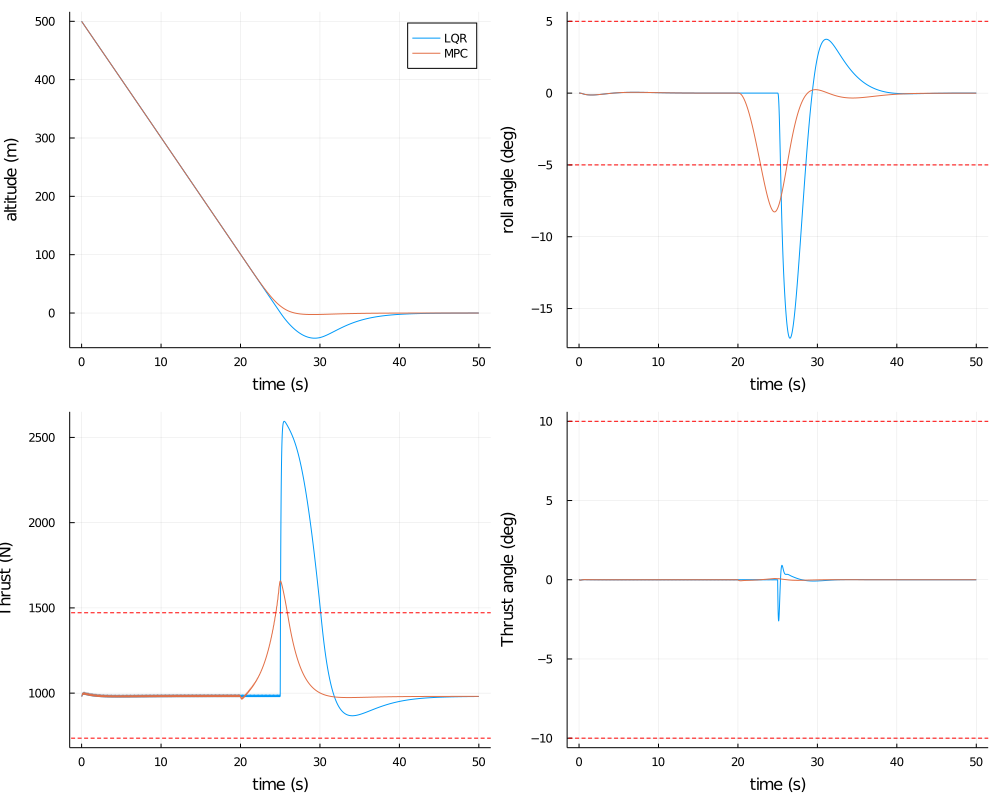

In [50]:
comparison_plot(model, (Xlqr,Ulqr,tlqr,"LQR"), (Xmpc1,Umpc1,tmpc1,"MPC"))

## Part (d): Add in Constraints
Add the following constraints to your optimization problem:
$$\begin{align}
    |\theta | &\leq 5^{\circ} \\
    |\phi| & \leq 10^{\circ} \\
    z &\geq 0 \\
    0.75 &\leq \frac{1}{mg} T \leq 1.5
\end{align}
$$

**TASK**: Modify the `build_QP` and `update_QP` methods above to add in the  constraints . You should add some logic that checks only adds the constraints if there's room in the matrices, that way we can still use the method to generate our unconstrained solver.

In [34]:
# Initialize the constrained MPC controller
Nd = (Nmpc-1)*(n+4)
mpc2 = OSQPController(n, m, Nmpc, length(Xref), Nd)
mpc2.Xref .= Xref
mpc2.Uref .= Uref
mpc2.times .= tref
buildQP!(mpc2, A,B,Q,R,Qf, tol=1e-2, verbose=false)

In [35]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("gimbal" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("cone" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6d, 0x62, 0x61, 0x6c, 0x2f, 0x63, 0x6f, 0x6e, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6d, 0x62, 0x61, 0x6c, 0x2f, 0x63, 0x6f, 0x6e, 0x65], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"tip" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x74, 0x69, 0x70], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"fins" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x69, 0x6e, 0x73], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8703))

In [36]:
Xmpc2,Umpc2,tmpc2 = simulate(model, Xref[1], mpc2, tf=50)
visualize!(vis, model, tmpc2[end] / 10, Xmpc2)

Controller ran at 1140.0781242110716 Hz


### Analyzing the results
Let's check our plots again to see how we did! You should see that the solution now (mostly) satisfies the constraints. You should notice that it violates the roll angle limit slightly. Why do you think that is? Is there a way we could prevent that? In the next (and last) section, we'll explore the effects of changing the MPC horizon.

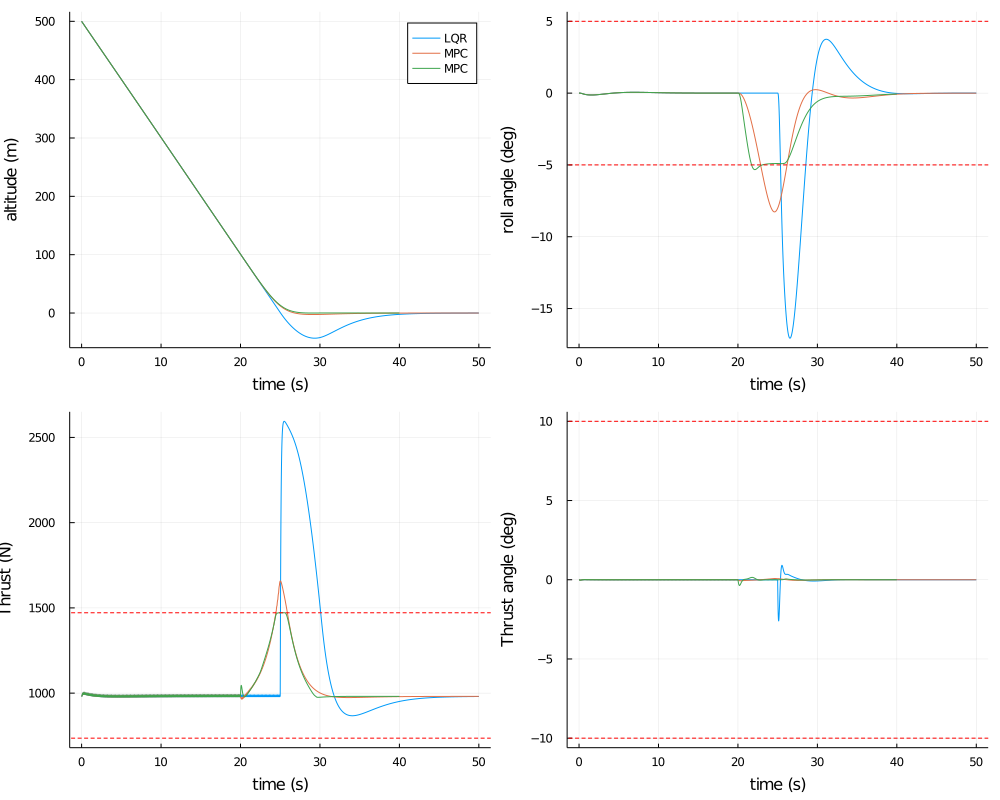

In [44]:
comparison_plot(model, (Xlqr,Ulqr,tlqr,"LQR"), (Xmpc1,Umpc1,tmpc1,"MPC"), (Xmpc2,Umpc2,tmpc2,"MPC"))

## Part (e): Changing the Horizon
Let's see how our solution changes with the horizon. Note, there's nothing we're asking you to do here, just take minute to look at the plots and convince yourself of what's going on.

In [61]:
# Run with a 1-step horizon
Nmpc = 2

# Constrained MPC
mpc3 = OSQPController(n, m, Nmpc, length(Xref))
mpc3.Xref .= Xref
mpc3.Uref .= Uref
mpc3.times .= tref
buildQP!(mpc3, A,B,Q,R,Qf, tol=1e-2, verbose=false)
Xmpc3,Umpc3,tmpc3 = simulate(model, Xref[1], mpc3, tf=50)

# Constrained MPC
Nd = (Nmpc-1)*(n+4)
mpc4 = OSQPController(n, m, Nmpc, length(Xref), Nd)
mpc4.Xref .= Xref
mpc4.Uref .= Uref
mpc4.times .= tref
buildQP!(mpc4, A,B,Q,R,Qf, tol=1e-2, verbose=false)
Xmpc4,Umpc4,tmpc4 = simulate(model, Xref[1], mpc4, tf=50);

Controller ran at 33995.005568797926 Hz
Controller ran at 52523.6009617879 Hz


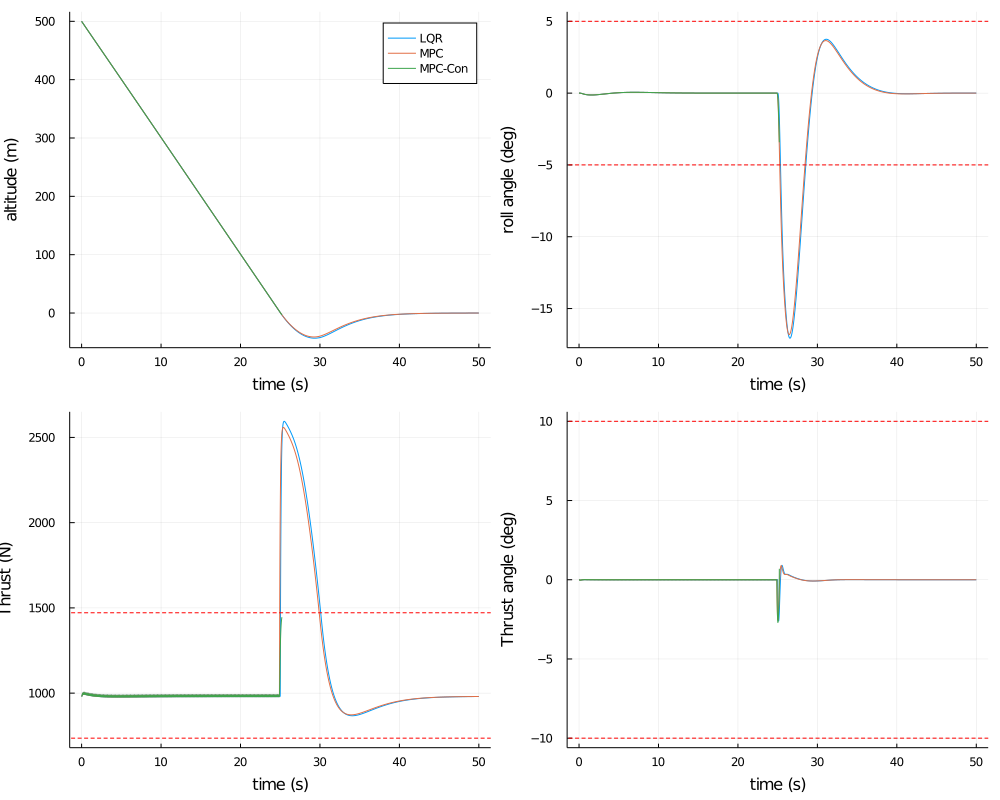

In [62]:
comparison_plot(model, (Xlqr,Ulqr,tlqr,"LQR"), (Xmpc3,Umpc3,tmpc3,"MPC"), (Xmpc4,Umpc4,tmpc4,"MPC-Con"))

In [76]:
# Run with a bunch of horizons
horizons = [21,31,41,51,61,71,81,91,101]

Z = map(horizons) do Nmpc
    # Constrained MPC
    println("running with horizon = $Nmpc")
    Nd = (Nmpc-1)*(n+4)
    mpc = OSQPController(n, m, Nmpc, length(Xref), Nd)
    mpc.Xref .= Xref
    mpc.Uref .= Uref
    mpc.times .= tref
    buildQP!(mpc, A,B,Q,R,Qf, tol=1e-2, verbose=false)
    Xmpc,Umpc,tmpc = simulate(model, Xref[1], mpc, tf=50);
    (Xmpc,Umpc,tmpc,"N = " * string(Nmpc))
end;

running with horizon = 21
Controller ran at 3048.2447581307933 Hz
running with horizon = 31
Controller ran at 2025.663897823909 Hz
running with horizon = 41
Controller ran at 1308.8856148398702 Hz
running with horizon = 51
Controller ran at 1097.2878823826031 Hz
running with horizon = 61
Controller ran at 921.0279159146789 Hz
running with horizon = 71
Controller ran at 748.3453628376463 Hz
running with horizon = 81
Controller ran at 695.906843860984 Hz
running with horizon = 91
Controller ran at 615.5460445763653 Hz
running with horizon = 101
Controller ran at 570.4598731708439 Hz


In [75]:
comparison_plot(model, Z...)

## Extra Credit: Use your QP Solver
You can earn some extra credit by using the AL QP solver you built in the previous homework. You'll get more extra credit if you modify your QP solver to handle the unique structure that exists in the MPC QP problem. Include an example of using your QP solver below, along with a description of your approach.